In [1]:
# import the libraries

import cv2
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pathlib
import PIL
import random
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50

In [2]:
# initialize the constants: 

INITIAL_LEARINGRATE = .001 # Initial Learning Rate
EPOCHS = 30 # Epochs
BATCH_SIZE = 32 # Batch Size
LENGTH = 224 # Length 
WIDTH = 224 # Width 

# Exploratory Data Analysis

In [3]:
# images without covid
wOut_Covid = list(pathlib.Path("../DATA").glob('0/*'))

# images with covid
w_Covid = list(pathlib.Path("../DATA").glob('1/*'))

There are 1301 images without Covid
There are 1790 images with Covid


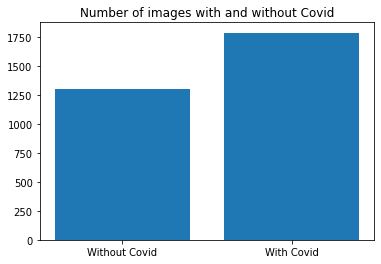

In [4]:
# number of images with and without covid

print('There are', len(wOut_Covid), 'images without Covid')
print('There are', len(w_Covid), 'images with Covid')

plt.bar(['Without Covid', 'With Covid'], [len(wOut_Covid), len(w_Covid)], align = 'center')
plt.title('Number of images with and without Covid')
plt.savefig('Fig1.jpeg', bbox_inches='tight') 
plt.show()

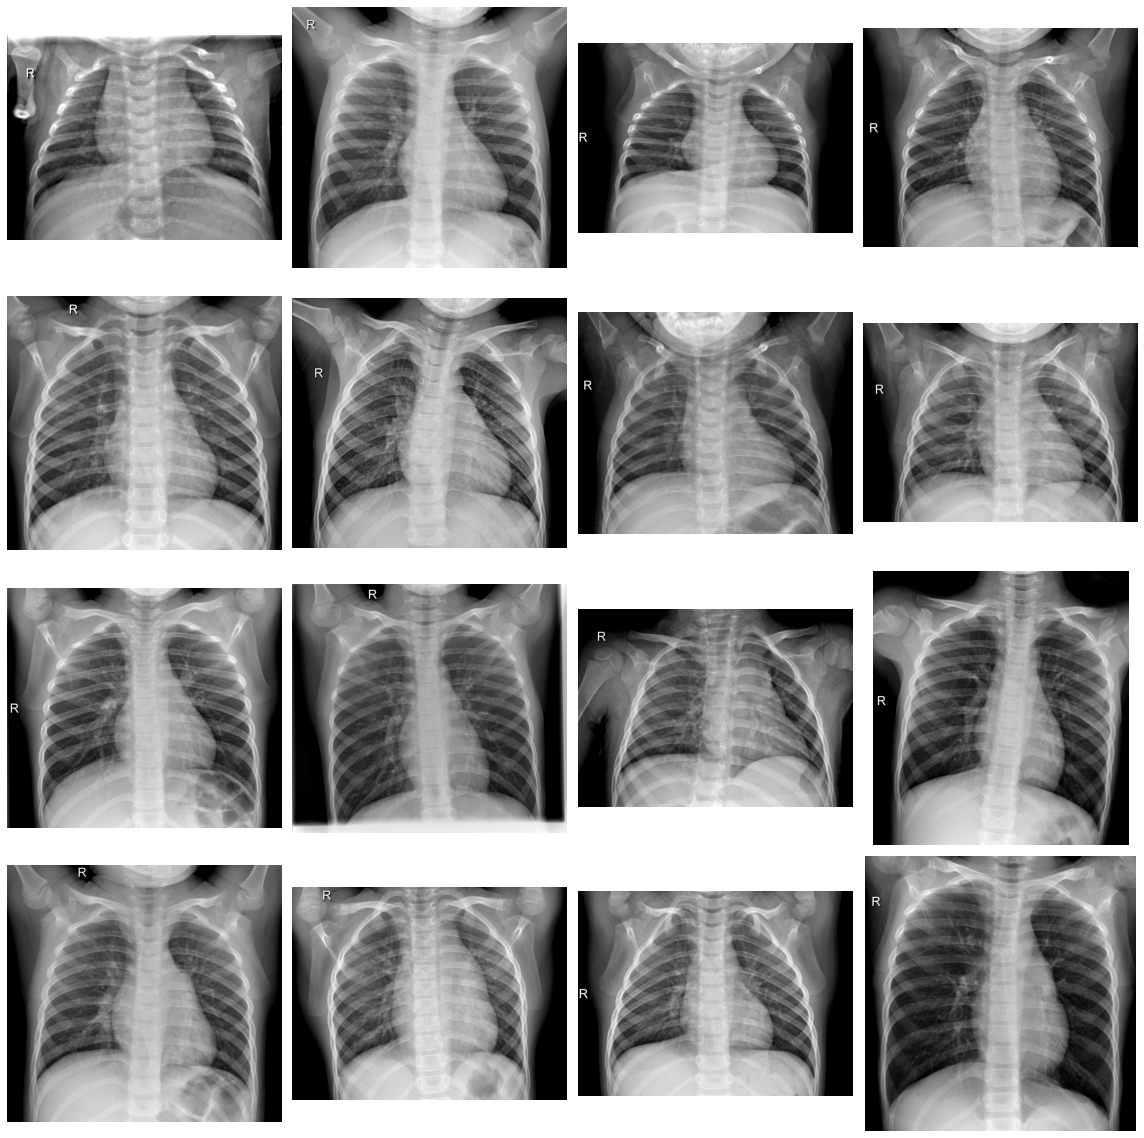

In [5]:
# grab the image path for the images without covid
image_dir = "../DATA/0/"

# create a 4x4 subplot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.ravel() # flatten the axes array

# get a list of all image files in the directory
image_files = [filename for filename in os.listdir(image_dir)]

# randomly select 16 images from the list
selected_files = random.sample(image_files, k=16)

# loop through the selected files
for i, filename in enumerate(selected_files):
    # load the image using matplotlib
    img = plt.imread(os.path.join(image_dir, filename))

    # display the image in the appropriate subplot
    axs[i].imshow(img.astype("uint8"))
    axs[i].axis('off')
     
# show the plot
plt.tight_layout()
plt.savefig('Fig2.jpeg', bbox_inches='tight') 
plt.show() 

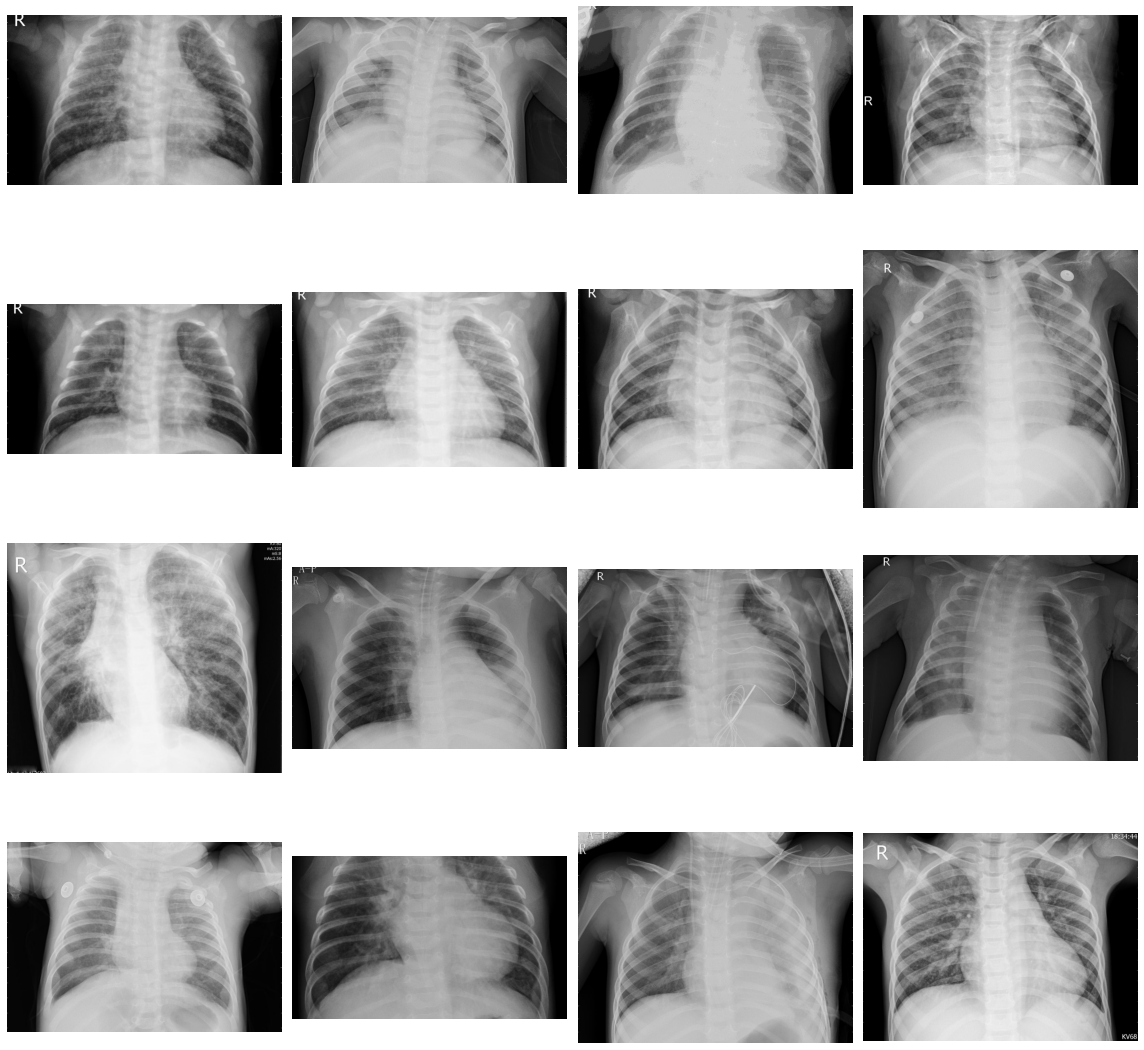

In [6]:
# grab the image path for the images with covid
image_dir = "../DATA/1/"

# create a 4x4 subplot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.ravel() # flatten the axes array

# get a list of all image files in the directory
image_files = [filename for filename in os.listdir(image_dir)]

# randomly select 16 images from the list
selected_files = random.sample(image_files, k=16)

# loop through the selected files
for i, filename in enumerate(selected_files):
    # load the image using matplotlib
    img = plt.imread(os.path.join(image_dir, filename))

    # display the image in the appropriate subplot
    axs[i].imshow(img.astype("uint8"))
    axs[i].axis('off')
     
# show the plot
plt.tight_layout()
plt.savefig('Fig3.jpeg', bbox_inches='tight') 
plt.show() 

# Preprocessing the Data

In [7]:
# take the images and put them into lists
image_path = list(paths.list_images(r"../DATA/"))

In [8]:
# create empty list for the data and the labels
data = list()
labels = list()

In [9]:
# now we want to loop over all the images in the files and then rescale them to a 224x224 aspect ratio. 
# this will be done via the CV library
for x in image_path:
    # getting the classlabel
    label = x.split(os.path.sep)[-2]

    # now, we load the image, change the color to RGB and then resize it
    image = cv2.imread(x)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(LENGTH,WIDTH))

    # update our label and data list
    labels.append(label)
    data.append(image)


In [10]:
# convert the data and labels to Numpy Arrays while scaling the pixel intensity
data = np.array(data) / 255.0 # 255 RGB colors
data.reshape(-1,1)
labels = np.array(labels)

In [11]:
# one-hot encoding the models
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [12]:
# creating our train and test data. Using standard practice, 80% of the dataset will be used for training 
# while the 20% will be used for testing
trainX, testX, trainY, testY = train_test_split(data,labels,test_size=.2, stratify=labels,random_state=42)

In [13]:
# initialize the training data augmentation object
train_augment = ImageDataGenerator(
    rotation_range = 15,
    fill_mode = 'nearest'
)

train_augment_bis = ImageDataGenerator(
    rotation_range = 10,
    fill_mode = 'nearest',
    zoom_range = 0.2,
    shear_range = 0.05
)

# Model

ResNet50 Model

In [14]:
# load the base model 
base_model = ResNet50(weights='imagenet', include_top=False,input_tensor=Input(shape=(LENGTH,WIDTH,3)))

In [15]:
# create the head of the model that is going to be on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(64, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

In [16]:
# now we will create our model; this model will be the one that is used to do the trainings
model = Model(inputs=base_model.input, outputs=head_model)

In [17]:
# freeze the layers of the base model so its not updated during the first training process
for y in base_model.layers:
    y.trainable = False

Compiling the Model

In [18]:
# using the ADAM optimizer to optimize
optimizer = Adam(learning_rate=INITIAL_LEARINGRATE, weight_decay = INITIAL_LEARINGRATE/EPOCHS)

In [19]:
# compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

Training the Network

In [20]:
# train the head of the network
head = model.fit(
    train_augment_bis.flow(trainX,trainY,batch_size=BATCH_SIZE),
    steps_per_epoch = len(trainX)//BATCH_SIZE,
    validation_data = (testX,testY),
    validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/30
77/77 [==============================] - 177s 2s/step - loss: 0.6874 - accuracy: 0.5811 - val_loss: 0.6566 - val_accuracy: 0.5784
Epoch 2/30
77/77 [==============================] - 163s 2s/step - loss: 0.6603 - accuracy: 0.6090 - val_loss: 0.6367 - val_accuracy: 0.5848
Epoch 3/30
77/77 [==============================] - 165s 2s/step - loss: 0.6420 - accuracy: 0.6193 - val_loss: 0.6169 - val_accuracy: 0.7787
Epoch 4/30
77/77 [==============================] - 162s 2s/step - loss: 0.6141 - accuracy: 0.6627 - val_loss: 0.5777 - val_accuracy: 0.6236
Epoch 5/30
77/77 [==============================] - 165s 2s/step - loss: 0.5969 - accuracy: 0.6586 - val_loss: 0.5397 - val_accuracy: 0.7771
Epoch 6/30
77/77 [==============================] - 162s 2s/step - loss: 0.5681 - accuracy: 0.6664 - val_loss: 0.5234 - val_accuracy: 0.8239
Epoch 7/30
77/77 [==============================] - 169s 2s/step - loss: 0.5486 - accuracy: 0.6730 - val_loss: 0.4921 - val_accuracy: 0.8029
Epoch 8/30
77

Making Predictions

In [21]:
# predicting using the trained model
predict = model.predict(testX,batch_size=BATCH_SIZE)

20/20 [==============================] - 35s 2s/step


In [22]:
# for each image, find the index of the label corresponding with the largest predicted probability
predict = np.argmax(predict,axis=1)

In [23]:
# now represent the prediction in a nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   ../DATA/0       0.77      0.92      0.83       261
   ../DATA/1       0.93      0.80      0.86       358

    accuracy                           0.85       619
   macro avg       0.85      0.86      0.85       619
weighted avg       0.86      0.85      0.85       619



Confusion Matrix for Statistical Evaluation

In [24]:
# create a confusion matrix consisting of accuracy, sensitivity, and specificity. 
confusionMatrix =confusion_matrix(testY.argmax(axis=1),predict)
total = sum(sum(confusionMatrix))

# caculate accuracy, sensitivity, and specificity
accuracy = (confusionMatrix[0,0] + confusionMatrix[1,1]) / total
sensitivity = confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
specificity = confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])

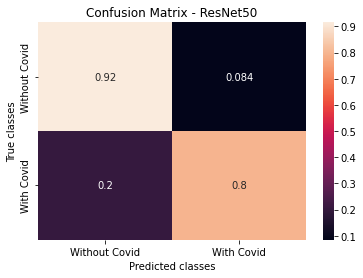

Accuracy:     0.847
Sensitivity:  0.916
Specificity:  0.796


In [25]:
# plot confusion matrix
confusionMatrix = confusion_matrix(testY.argmax(axis=1),predict, normalize = 'true')
sns.heatmap(confusionMatrix, annot=True)
plt.title('Confusion Matrix - ResNet50')
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.yticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.savefig('Fig4.jpeg', bbox_inches='tight')
plt.show()

# display the output
print("Accuracy:    ", round(accuracy,3))
print("Sensitivity: ", round(sensitivity,3))
print("Specificity: ", round(specificity,3))

Plot for Visual Representation

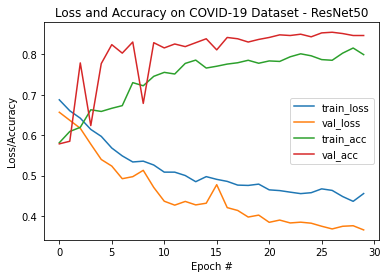

In [26]:
# graph for visual representation
plt.plot(np.arange(0, EPOCHS), head.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), head.history["val_accuracy"], label="val_acc")
plt.title("Loss and Accuracy on COVID-19 Dataset - ResNet50")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('Fig5.jpeg', bbox_inches='tight')
plt.show()